In [ ]:
# A rewrite of the code to make it easier to deal with. 
# We now allow for a multi-grid solver with uneven lengths and different resolutions.
# State vector: [t, ξ, p_2, a_4], var_vec.
# var_vec: Phi, S, Sdot, PhiDot, A.
# 
# T = BigFloat;
# setprecision(T,128)

T = Float64;

# --------------------------------------------------------------
#  Struct definition: this holds all variables at a grid point.
# --------------------------------------------------------------/

struct PDEVars{T}
    Phi::T
    S::T
    Sdot::T
    Phidot::T
    A::T
    PhiZ::T
    SZ::T
    SdotZ::T
    PhidotZ::T
    AZ::T
    PhiZZ::T
    SZZ::T
    SdotZZ::T
    PhidotZZ::T
    AZZ::T
    z::T
    LN::T
    t::T
    X::T
    p2::T
    a4::T
    DS0::T
    DS1::T
    DS2::T
    DS3::T
    DS4::T
end

using Plots
using Parameters: @unpack

include("cheb.jl")
include("Equation expressions/ODECoeffExpr.jl");
include("Equation expressions/CosmoS0Expr.jl");
include("Equation expressions/CosmoTimeStepExpr.jl");
include("Equation expressions/CosmoConstrExpr.jl");
include("solvers.jl")

#Properties of this simulation:

global const H = T(2.);
global const Om = T(8.);
global const tstar = 1;
global const M = T(1.);
global zAH = T(1/2);

global const z_boundaries = [zero(T), T(0.1),T(0.25), T(0.4), T(0.5)]; #Boundaries of grid domains.
global const domain_sizes = [10, 20, 20, 10]; #sizes of all domains.
global const Ndom = length(domain_sizes);
global const N = sum(domain_sizes);

global domAH = 4;
global indAH = 10;

global const zero_var = [zeros(T,n) for n in domain_sizes]; #Helpful for getting arrays of the right shape

diff2_mats, diff1_mats, grids, damp_mats = MultiGridChebyshev(z_boundaries,domain_sizes);

Vfun(x) = ( -576. - 288. * x^2 - 64. * x^4 + 22. * x^6 - x^8) / 192.;
DV(x) = - x * (144. + 64. * x^2 - 33. * x^4 + 2. * x^6) / 48.;


In [128]:
init_guess = [copy(zero_var) for var in 1:NVar];
Var = copy(init_guess);

In [129]:
init_params = [T(-1), T(1.2325928433658935), 0., -T(100.)];
init_guess = [copy(zero_var) for var in 1:NVar];


In [118]:

# Var = copy(init_guess);
# VarZ,VarZZ = ComputeDerivatives(Var);

# for ii in 1:200
#     Var[ind_s] = LinearSolveODE(1, init_params, Var, VarZ, VarZZ);
#     VarZ[ind_s] = ComputeSingleDerivative(Var[ind_s]);
#     VarZZ[ind_s] = ComputeSingleDerivative(Var[ind_s], deg=2);

#     Var[ind_sdot] = LinearSolveODE(2, init_params, Var, VarZ, VarZZ);
#     VarZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot]);
#     VarZZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot], deg=2);

#     newX = CorrectXi(init_params, Var);
#     print("\rX = $newX");
#     flush(stdout);

#     init_params[ind_X] = newX;
# end

In [130]:
InitVar = ComputeBulk(init_params, Var);

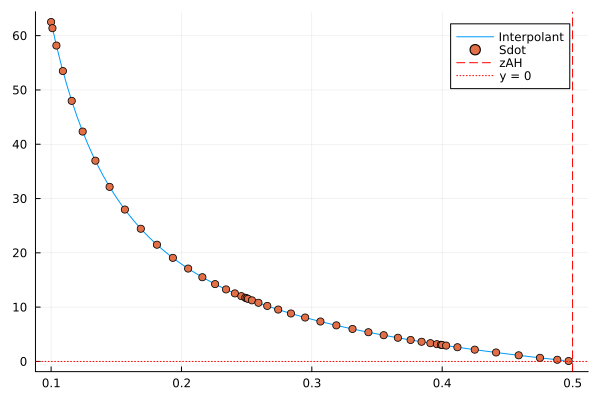

In [131]:
fig = PlotSdot(init_params,InitVar);
display(fig)

In [134]:
dt = T(.00002);


outfile = [];
monitorfile = [];

FinalParams, VarFinal = Evolve(init_params,InitVar, 4, dt, 500, outfile, monitorfile);

# close(outfile);
# close(monitorfile);

◓ time = 4.000, constraint violation = 7731.384,  Sdot at zAH = 0.043    Time: 1:54:34

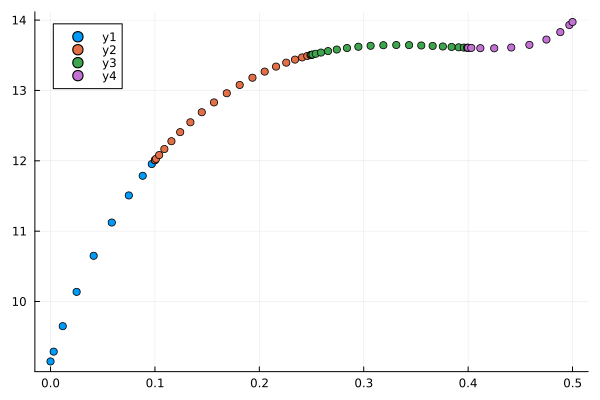

In [135]:
scatter(grids,outfile[end][1])

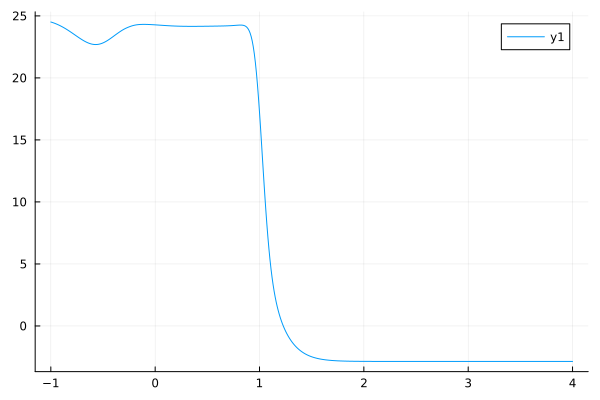

In [136]:
plot([x[1] for x in monitorfile],[x[4] for x in monitorfile])

In [137]:
infP = monitorfile[end][4]

-2.861719726961199306288386543579710678088

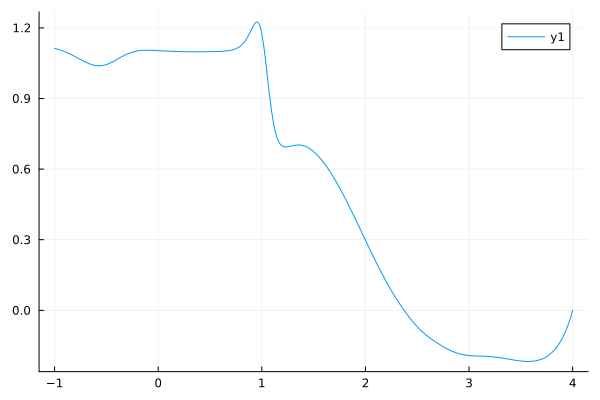

In [138]:
plot([x[1] for x in monitorfile],[3*(x[4]-infP)/(x[3]+infP) for x in monitorfile])

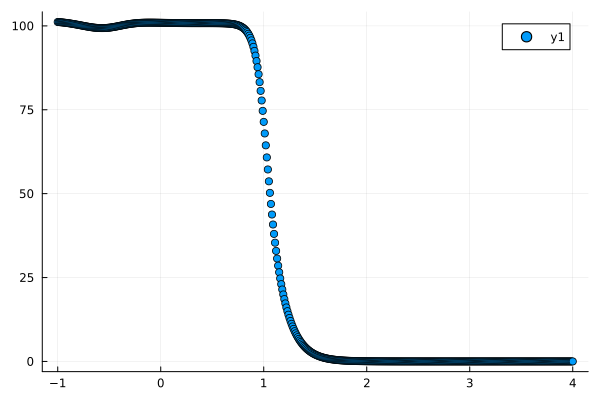

In [139]:
scatter([x[1] for x in monitorfile],[abs(x[3]+x[4]) for x in monitorfile])

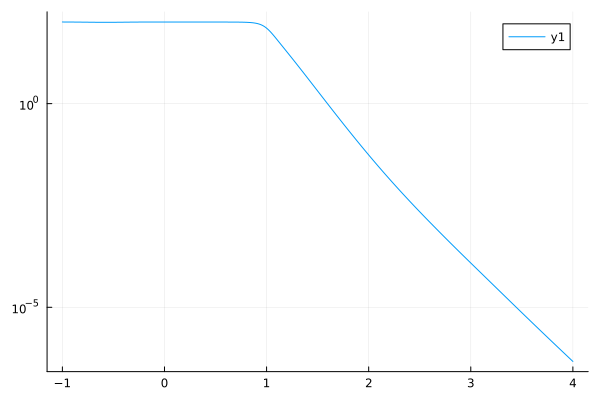

In [140]:
plot([x[1] for x in monitorfile],[abs(x[3]+x[4]) for x in monitorfile],yscale=:log10)

In [141]:
length(monitorfile)

501

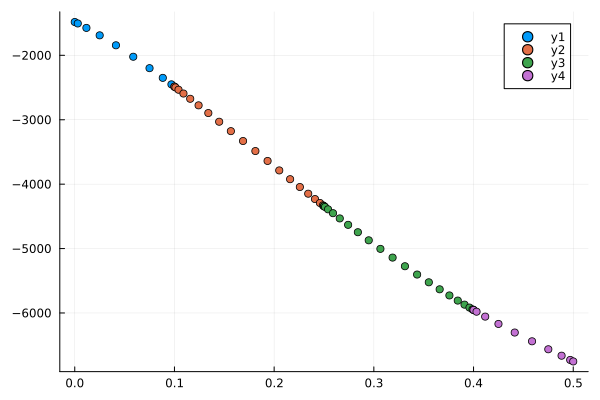

In [142]:
scatter(grids, VarFinal[ind_s])

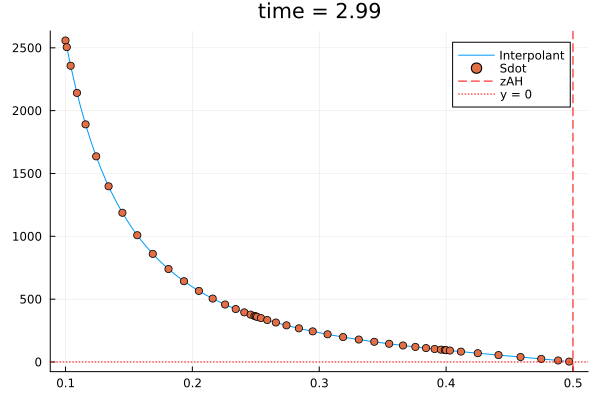

In [143]:
ind =400;
fig = PlotSdot([monitorfile[ind][1], monitorfile[ind][2], outfile[ind][1][1][1],outfile[ind][5][1][1]],outfile[ind][:]);
title!(fig, string("time = ",format(monitorfile[ind][1],precision=2)))
display(fig)

In [ ]:
# using Serialization

# open("Data files/H2Run.dat","w") do io
#     serialize(io, [outfile, monitorfile]);
# end